# Receipt OCR

#### Installation of Dependencies 

In [7]:
# ! pip install opencv-python numpy pytesseract PaddleOCR easyocr

In [8]:
import cv2
import numpy as np
import pytesseract
from paddleocr import PaddleOCR
import easyocr
import os
import pandas as pd
import matplotlib.pyplot as plt

#### Helper Function to Show Images

In [9]:
def show(image):
    resized_height = 720
    percent = resized_height / len(image)
    resized_width = int(percent * len(image[0]))
    img = cv2.resize(image,(resized_width,resized_height))

    # cv2.imshow('image', img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.imshow(img, cmap='gray')   
    plt.axis('off')

#### Loading Image

In [10]:
image_path = 'images/receipt2.jpeg'
# image_path = 'images/receipt_image.jpg'

In [11]:
image = cv2.imread(image_path, 0)
color = cv2.imread(image_path)

hsv = cv2.cvtColor(color, cv2.COLOR_BGR2HSV)

hue, saturation, value = cv2.split(hsv)

### Extracting Receipt from the Image

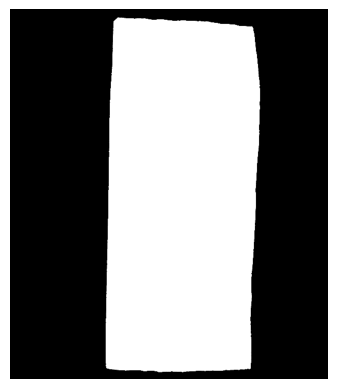

In [12]:
if np.mean(color) < 128:
    thresh = cv2.threshold(hue, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
else:
    thresh = cv2.threshold(hue, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

show(thresh)


In [13]:
eroded = cv2.erode(thresh, kernel=None, iterations=7)
dilated = cv2.dilate(eroded, kernel=None, iterations=15)
eroded = cv2.erode(dilated, kernel=None, iterations=100)
dilated = cv2.dilate(eroded, kernel=None, iterations=100)

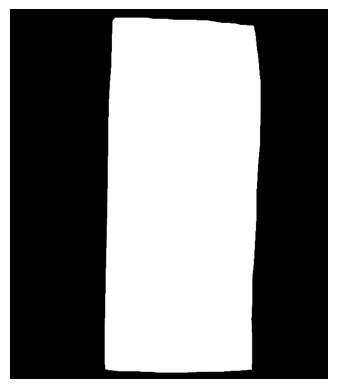

In [14]:
show(dilated)

In [15]:
def extract_largest_rectangular_contour(color_image, preprocessed_image):
    color_image = color_image.copy()
    contours, _ = cv2.findContours(preprocessed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = None
    largest_area = 0
    largest_approx = None
    
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:
            area = cv2.contourArea(contour)
            if area > largest_area:
                largest_area = area
                largest_contour = contour
                largest_approx = approx
                
    if largest_contour is not None:
        cv2.drawContours(color_image, [largest_approx], -1, (0, 255, 0), 3)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cv2.rectangle(color_image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        return color_image, largest_approx
    
    return color_image, None

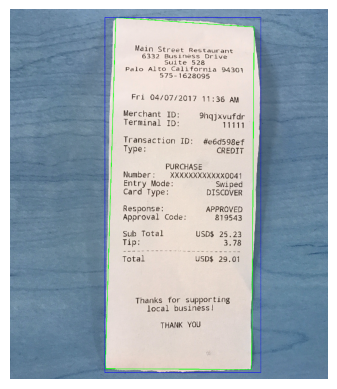

In [16]:
im, cor = extract_largest_rectangular_contour(color, dilated)
show(im)

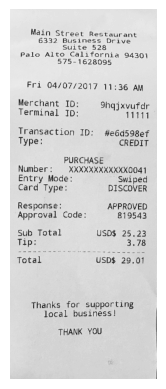

In [17]:
top = max(cor[0][0][1], cor[3][0][1])
bottom = min(cor[1][0][1], cor[2][0][1])
left = max(cor[0][0][0], cor[1][0][0])
right = min(cor[2][0][0], cor[3][0][0])
cropped = image[top:bottom, left:right]
show(cropped)


### Perspective Correction

In [18]:
def order_points(coords):
    pts = coords - [left, top]
    pts = pts.reshape(4, 2)
    sum_pts = pts.sum(axis=1)
    diff_pts = np.diff(pts, axis=1)
    
    top_left = pts[np.argmin(sum_pts)]
    top_right = pts[np.argmin(diff_pts)]
    bottom_right = pts[np.argmax(sum_pts)]
    bottom_left = pts[np.argmax(diff_pts)]
    
    return np.array([top_left, top_right, bottom_right, bottom_left])

def calculate_size(img, ordered):
    width = int(img.shape[1] * 0.8)
    aspect_ratio = np.linalg.norm(ordered[0] - ordered[3]) / np.linalg.norm(ordered[0] - ordered[1])
    return width, int(width * aspect_ratio)

def process_image(img, contour):
    ordered = order_points(contour)
    img_with_pts = img.copy()
    for pt in ordered:
        img_with_pts = cv2.circle(img_with_pts, tuple(pt), 10, (255, 255, 255), -1)
  
    w, h = calculate_size(img, ordered)
    
    pts1 = np.float32(ordered)
    pts2 = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    
    corrected_img = cv2.warpPerspective(img, matrix, (w, h))
    
    return img_with_pts, corrected_img

True

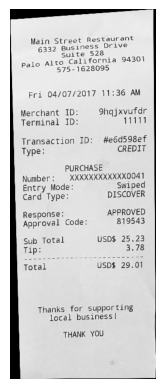

In [19]:
_, corrected = process_image(cropped, cor)
show(corrected)
cv2.imwrite('output/images/perspective_1.jpg', corrected)

### Pre-processing for OCR

In [20]:
def unsharp_masking(image, k=1):
    blur = cv2.GaussianBlur(image, (11,11), 0)
    return cv2.addWeighted(image, k+1, blur, -k, 1)

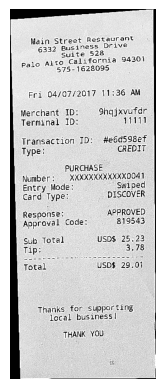

In [21]:
unsharp = unsharp_masking(corrected, 11)
show(unsharp)


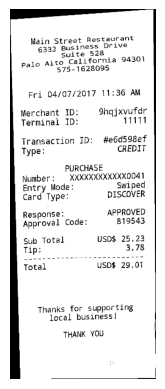

In [22]:
thresh = np.where(unsharp > 64, 255, 0).astype(np.uint8)
show(thresh)


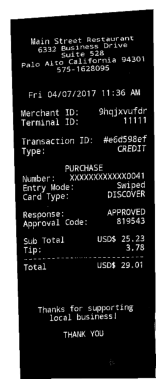

In [23]:
thresh_inv = cv2.bitwise_not(thresh)
show(thresh_inv)


In [24]:
image_save_path = 'output/corrected_image_1.jpg'
# cv2.imwrite(image_save_path, thresh)

### Segmenting Image for OCR

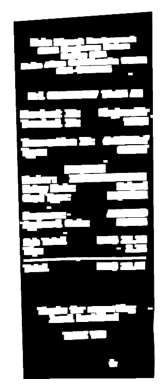

In [25]:
elong = cv2.dilate(thresh_inv, kernel=np.ones((2,4)), iterations=7)
elong = cv2.dilate(elong, kernel=np.ones((2,2)), iterations=5)
show(elong)


In [26]:
corr = corrected.copy()
corr = cv2.cvtColor(corr, cv2.COLOR_GRAY2BGR)
bounding = []
contours = cv2.findContours(elong, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    
    if w*h < 500:
        continue
    
    bounding.append((x,y,w,h))
    corr = cv2.rectangle(corr, (x,y), (x+w, y+h), (0,255,0), 5)

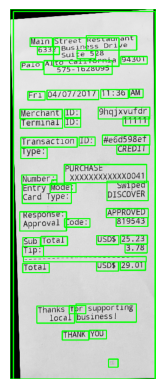

In [27]:
show(corr)

In [28]:
for x,y,w,h in bounding:
    image_slice = corrected[y:y+h, x:x+w]
    image_slice_path = "output/slices/img_" + f"{x}{y}{w}{h}" + ".jpg"
    cv2.imwrite(image_slice_path, image_slice)

#### Optical Character Recognition (OCR)

In [29]:
def ocr(image, option):
    text_data = []

    if option == 1:
        text = pytesseract.image_to_string(image)
        sentences = text.split('\n')
        text_data.extend(sentences)
    
    elif option == 2:
        ocr = PaddleOCR(use_angle_cls=True, lang='en')  
        result = ocr.ocr(image, cls=True)
        for line in result[0]:
            text_data.append(line[1][0])
    
    elif option == 3:
        reader = easyocr.Reader(['en'])
        result = reader.readtext(image)
        for detection in result:
            text_data.append(detection[1])
            
    return text_data

#### OCR with full Image

In [30]:
test_img = cv2.imread(image_save_path)

In [31]:
text=ocr(test_img, 1)
output_text_path='output/text/pytesseract_text.csv'
df = pd.DataFrame(text)
df.to_csv(output_text_path, index=False)

In [32]:
text=ocr(test_img, 2)
output_text_path='output/text/paddle_text.csv'
df = pd.DataFrame(text)
df.to_csv(output_text_path, index=False)

[2024/11/09 02:55:50] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/ankur/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/ankur/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode

In [33]:
text=ocr(test_img, 3)
output_text_path='output/text/easy_text.csv'
df = pd.DataFrame(text)
df.to_csv(output_text_path, index=False)

#### OCR with Segmented Image

In [ ]:
input_path='output/slices/'

In [ ]:
data=[]
for file_name in os.listdir(input_path):
    file_path = os.path.join(input_path, file_name)
    if os.path.isfile(file_path):
        image = cv2.imread(file_path)
        text=ocr(image, 1)
        data.extend(text)
output_text_path='output/text/pytesseract_segmented_text.csv'
df = pd.DataFrame(data)
df.to_csv(output_text_path, index=False)

In [ ]:
data=[]
for file_name in os.listdir(input_path):
    file_path = os.path.join(input_path, file_name)
    if os.path.isfile(file_path):
        image = cv2.imread(file_path)
        text=ocr(image, 1)
        data.extend(text)
output_text_path='output/text/paddle_segmented_text.csv'
df = pd.DataFrame(data)
df.to_csv(output_text_path, index=False)

In [ ]:
data=[]
for file_name in os.listdir(input_path):
    file_path = os.path.join(input_path, file_name)
    if os.path.isfile(file_path):
        image = cv2.imread(file_path)
        text=ocr(image, 1)
        data.extend(text)
output_text_path='output/text/easy_segmented_text.csv'
df = pd.DataFrame(data)
df.to_csv(output_text_path, index=False)